## Chapter 24 - Count Predicted Variable

- [24.2 - Example: Hair Eye Go Again](#24.2---Example:-Hair-Eye-Go-Again)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from matplotlib import gridspec
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':14}

In [2]:
def gammaShRaFromModeSD(mode, sd):
    """Calculate Gamma shape and rate from mode and sd."""
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

### 24.2 - Example: Hair Eye Go Again

#### Data

In [3]:
df = pd.read_csv('data/HairEyeColor.csv', dtype={'Hair':'category', 'Eye':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
Hair     16 non-null category
Eye      16 non-null category
Count    16 non-null int64
dtypes: category(2), int64(1)
memory usage: 304.0 bytes


In [4]:
df['Prop'] = df.Count.apply(lambda x: x/df.Count.sum())
df.head()

,Hair,Eye,Count,Prop
0,Black,Blue,20,0.033784
1,Black,Brown,68,0.114865
2,Black,Green,5,0.008446
3,Black,Hazel,15,0.025338
4,Blond,Blue,94,0.158784


In [5]:
df_pivot = df.pivot('Eye', 'Hair')
df_pivot

Count                      Prop                              
Hair  Black Blond Brown Red     Black     Blond     Brown       Red
Eye                                                                
Blue     20    94    84  17  0.033784  0.158784  0.141892  0.028716
Brown    68     7   119  26  0.114865  0.011824  0.201014  0.043919
Green     5    16    29  14  0.008446  0.027027  0.048986  0.023649
Hazel    15    10    54  14  0.025338  0.016892  0.091216  0.023649

#### Model (Kruschke, 2015)

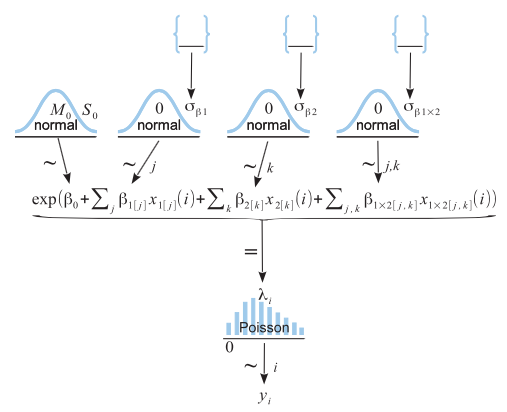

In [6]:
Image('images/fig24_2.png')

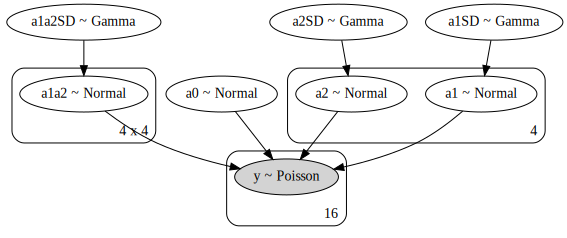

In [7]:
y = df.Count
x1 = df.Eye.cat.codes.values
x2 = df.Hair.cat.codes.values
Nx1Lvl = len(df.Eye.cat.categories)
Nx2Lvl = len(df.Hair.cat.categories)
Ncell = df.Count.size

yLogMean = np.log(np.sum(y)/(Nx1Lvl*Nx2Lvl))
yLogSD = np.log(np.std(np.r_[np.repeat([0], Ncell-1), np.sum(y)], ddof=1))
agammaShRa = gammaShRaFromModeSD(yLogSD, 2*yLogSD)

with pm.Model() as poisson_model:
        a0 = pm.Normal('a0', yLogMean, tau=1/(yLogSD*2)**2)

        a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
        a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
        
        a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
        a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
        
        a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
        a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
        
        lmbda = pm.math.exp(a0 + a1[x1] + a2[x2] + a1a2[x1, x2])
        
        like = pm.Poisson('y', lmbda, observed=y)
        
pm.model_to_graphviz(poisson_model)

In [8]:
n_samples = 3000
with poisson_model:
    trace1 = pm.sample(n_samples, cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1a2, a1a2SD, a2, a2SD, a1, a1SD, a0]
Sampling 4 chains: 100%|██████████| 14000/14000 [02:54<00:00, 80.06draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


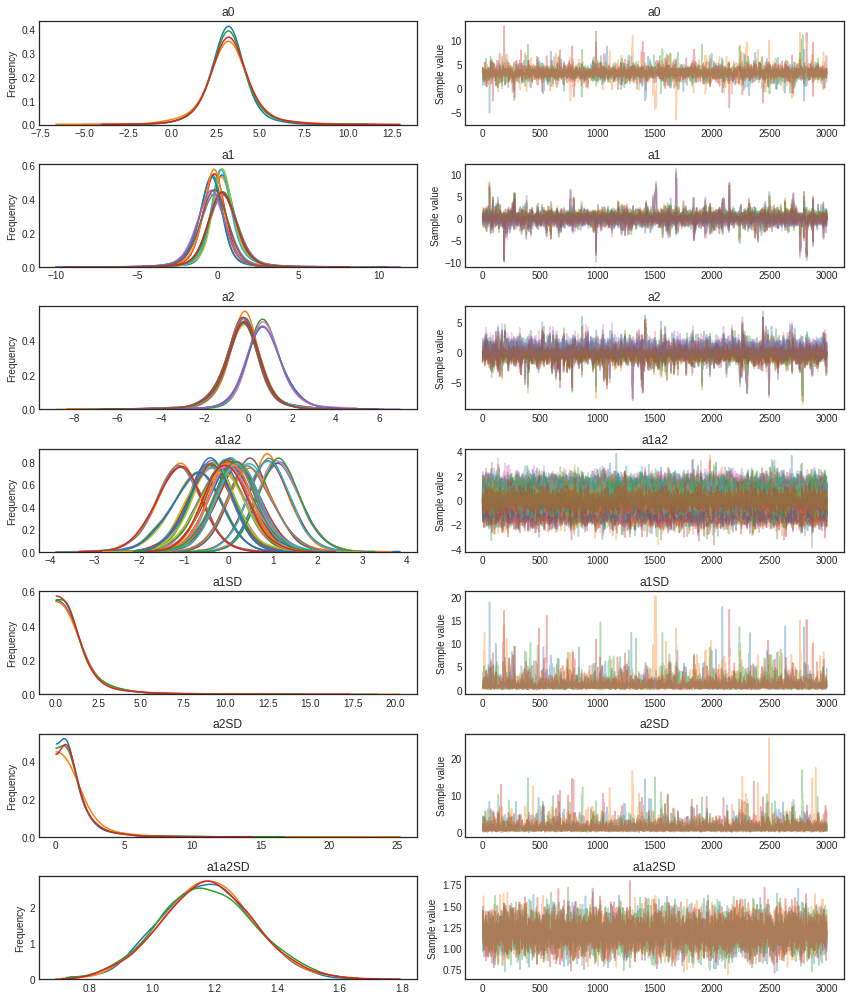

In [9]:
pm.traceplot(trace1);

In [10]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl,Nx2Lvl, trace1.nchains*n_samples))
b1b2 = m.copy()

for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        m[j1,j2] =  (trace1['a0'] +
                     trace1['a1'][:,j1] +
                     trace1['a2'][:,j2] +
                     trace1['a1a2'][:,j1,j2])

b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0
        
for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))

# Compute predicted proportions
expm = np.exp(m)
ppx1x2p = expm/np.sum(expm, axis=(0,1))

#### Figure 24.3

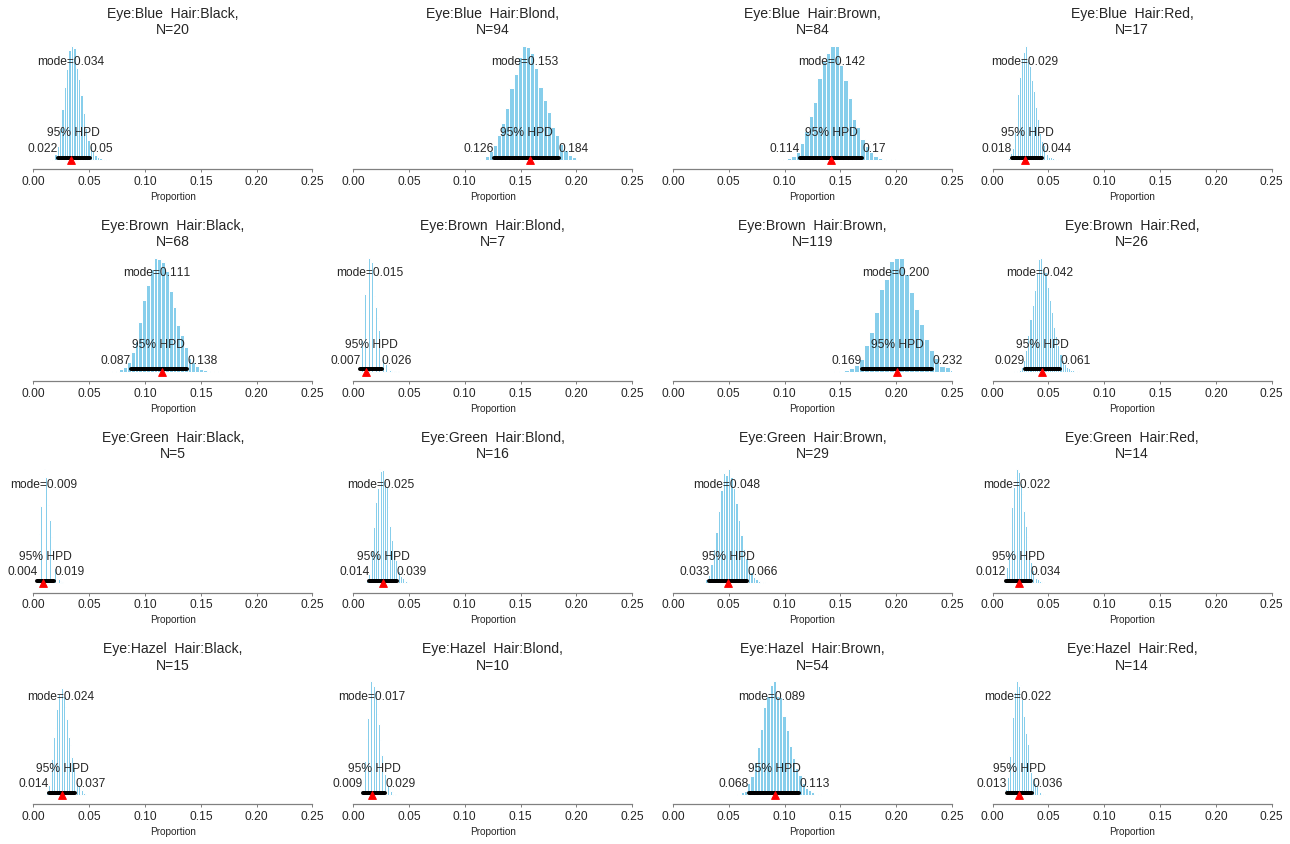

In [11]:
# Define gridspec
fig, axes = plt.subplots(4,4, figsize=(18,12))
for (r, c), ax in np.ndenumerate(axes):
    ax = pm.plot_posterior(ppx1x2p[r,c,:], point_estimate='mode', color=color, ax=ax)
    ax.scatter(df_pivot['Prop'].iloc[r,c], 0, s=60, c='r', marker='^', zorder=5)
    ax.set_title('Eye:{}  Hair:{},\nN={}'.format(df_pivot.index[r],
                                                df_pivot['Count'].columns[c],
                                                df_pivot['Count'].iloc[r,c]),
                 fontdict=f_dict)
    ax.set_xlim(left=.0, right=.25)
    ax.set_xlabel('Proportion')
fig.tight_layout(pad=1.7);

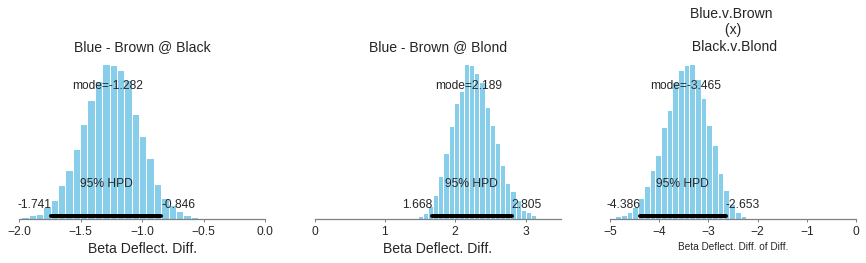

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,3))

blue_black = b1b2[0,0]
brown_black = b1b2[1,0]
blue_blond = b1b2[0,1]
brown_blond = b1b2[1,1]

# [1] Deflection difference between blue and brown eyes, for black hair
pm.plot_posterior(blue_black - brown_black, point_estimate='mode', color=color, ax=ax1)
ax1.set_title('Blue - Brown @ Black', fontdict=f_dict)
ax1.set_xlim(-2,0)

# [2] Deflection difference between blue and brown eyes, for blond hair
pm.plot_posterior(blue_blond - brown_blond, point_estimate='mode', color=color, ax=ax2)
ax2.set_title('Blue - Brown @ Blond', fontdict=f_dict)
ax2.set_xlim(0,3.5)

for ax in [ax1, ax2]:
    ax.set_xlabel('Beta Deflect. Diff.', fontdict=f_dict)
# [3] Difference of differences: [1] - [2]
pm.plot_posterior((blue_black - brown_black) - (blue_blond - brown_blond),
                  point_estimate='mode', color=color, ax=ax3)
ax3.set_title('Blue.v.Brown \n (x) \n Black.v.Blond', fontdict=f_dict)
ax3.set_xlim(-5,0)
ax3.set_xlabel('Beta Deflect. Diff. of Diff.');